**Input:** Text

**Output:** Sentiment Label [0, 1, 2]

- **0:** Negative Sentiment
- **1:** Neutral Sentiment
- **2:** Positive Sentiment

In [3]:
import re
import string
import numpy as np
import pandas as pd

from pythainlp import word_tokenize
from pythainlp.util import normalize
from pythainlp.corpus import thai_stopwords
from pythainlp import word_tokenize

from keras import regularizers
from keras import backend as K
from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, BatchNormalization, SpatialDropout1D
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight


In [5]:
train_df = pd.read_csv('train.csv')


### Preprocess

In [6]:
train_df['length'] = train_df['texts'].apply(word_tokenize).apply(len)


In [7]:
train_df = train_df[train_df['length'] < train_df['length'].quantile(0.95)]

In [8]:
train_df = train_df[train_df['length'] >= train_df['length'].quantile(0.05)]

In [9]:
train_df.category.value_counts()

neu    11886
neg     5984
pos     4100
Name: category, dtype: int64

In [10]:
class_names = np.unique(train_df.category).tolist()
class_names

['neg', 'neu', 'pos']

In [11]:
train_df

,category,texts,length
0,neu,ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ,13
2,neg,อิเหี้ยออมทำกูอยากกินเอ็มเค,9
4,neu,สวัสดีวันพุธ แนน อะไรนะ,8
5,neu,ก้อนขอบพระคุณมากๆนะคร้าบ ที่มาหาก้อนและชมเชยกา...,23
7,neu,ปากแดงกินฟรีค่ะ 😬😬,7
...,...,...,...
23540,neg,แม่งควายล้วนนน,5
23541,neg,ดอยสุเทพน้องง ไปหมดแล้วววว #pm25,13
23542,neg,ค่าชุดอาจจะแพงกว่าส่วนลด,6
23543,neu,รัฐต้องการแค่ภาษีครับ,5


In [12]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### **Preprocess**


#### Tokenizer
Before training, I converted text to numbers because models learn only from numerical. Breaking down long sentences into individual words   simplify the learning process of the model


for example

In [61]:
train_df['texts'][0]

'ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ'

In [13]:
word_tokenize(train_df['texts'][0])

['ประเทศ',
 'เรา',
 'ผลิต',
 'และ',
 'ส่งออก',
 'ยาสูบ',
 'เยอะ',
 'สุด',
 'ใน',
 'โลก',
 'จิง',
 'ป่าว',
 'คับ']

In [62]:
# Tokenize using pythainlp
train_df['tokenized_texts'] = train_df['texts'].apply(word_tokenize)

# Create a dictionary mapping words to unique integer indices
word_index = {}
for words_list in train_df['tokenized_texts']:
    for word in words_list:
        if word not in word_index:
            word_index[word] = len(word_index) + 1  # Start indexing from 1

# Convert the text sequences to integer sequences based on the word_index
train_df['sequences'] = train_df['tokenized_texts'].apply(lambda words_list: [word_index[word] for word in words_list])

# Get the maximum sequence length
max_length = max(len(sequence) for sequence in train_df['sequences'])
print("Maximum Sequence Length:", max_length)

Maximum Sequence Length: 99


### Padding sequence

help us receive input text sentences with different range for training with neural network that have to fixed size input by multiplying input method like zero padding


for example

Original Sequence 1: `[1, 2, 3]` | Padded Sequence 1: `[0, 1, 2, 3]`

Original Sequence 2: `[4, 5]` | Padded Sequence 2: `[0, 0, 4, 5]`



In [14]:
# Padding sequences
X = pad_sequences(train_df['sequences'], maxlen=max_length)

# Converting labels to numerical format
le = LabelEncoder()
__y = le.fit_transform(train_df['category'])
_y = __y.copy()
y = to_categorical(_y)

# Vocabulary size
vocab_size = len(word_index) + 1
print("Vocabulary size:", vocab_size)


Maximum Sequence Length: 99
Vocabulary size: 23825


In [15]:
train_df['tokenized_texts']

0        [ประเทศ, เรา, ผลิต, และ, ส่งออก, ยาสูบ, เยอะ, ...
2            [อิ, เหี้ย, ออม, ทำ, กู, อยาก, กิน, เอ็ม, เค]
4                  [สวัสดี, วัน, พุธ,  , แนน,  , อะไร, นะ]
5        [ก้อน, ขอบพระคุณ, มาก, ๆ, นะ, คร้าบ,  , ที่, ม...
7                         [ปาก, แดง, กิน, ฟรี, ค่ะ,  , 😬😬]
                               ...                        
23540                             [แม่, ง, ควาย, ล้วน, นน]
23541    [ดอย, สุเทพ, น้อง, ง,  , ไป, หมด, แล้ว, ววว,  ...
23542                 [ค่า, ชุด, อาจจะ, แพง, กว่า, ส่วนลด]
23543                      [รัฐ, ต้องการ, แค่, ภาษี, ครับ]
23544    [™,  , ได้, พัฒนา, ระบบ, เข้าสู่, รุ่น, ที่สอง...
Name: tokenized_texts, Length: 21970, dtype: object

### "LSTM" Model

Reason why picking up lstm

- LSTM suitable for sequential data, like sentiment analysis "LSTM is designed to capture long range dependency"

- LSTM handling vanishing gradient; memory cell, forget gate, residual connection to help the network remember the previous sentences and forgot unneccessary input and skip connection to prevent vanishing gradient when sentences is long.

- Memory cell, LSTM can store and retrieve information over long periods so it will allow to remember contextual information

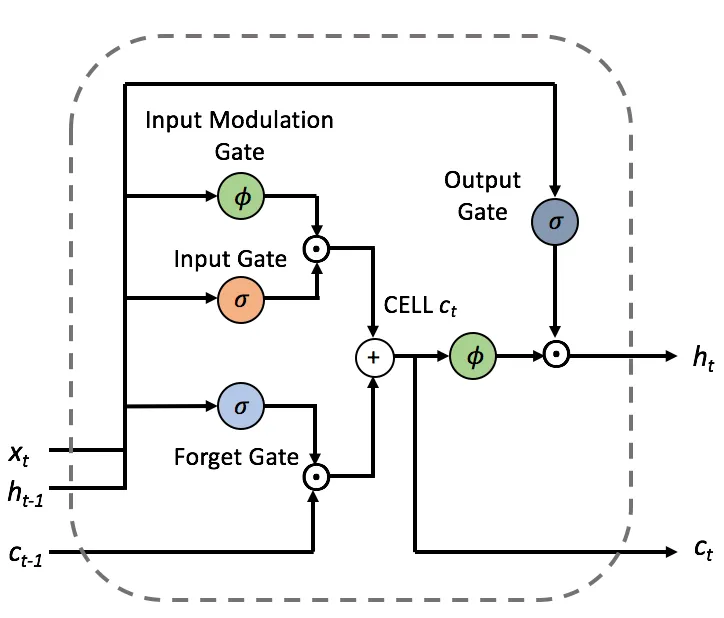

How's LSTM work

1. Input Sequences: the input sequences consists of sequence of words. Each words represent as a vector

2. Sequence processing: LSTM process the input one element at a time so it can capture information from earlier parts of the sentences

3. Memory Cells: select remember or forget information over long sequences

4. Gates: LSTM gate control the information in and out
    Input Gate: Decides which information to add to the memory cell.
    Forget Gate: Decides which information to discard from the memory cell.
    Output Gate: Decides what to output based on the current input and the memory cell's content.
5. Backpropagation Through Time
    It propagates the error back through the entire sequence, updating the weights at each time step to improve the model's performance.

In [16]:
initial_learning_rate = 1e-3
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9
)

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    SpatialDropout1D(0.5),  
    Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0, return_sequences=True)),
    Bidirectional(LSTM(64, dropout=0.5, recurrent_dropout=0)),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(3, activation='softmax')
])
optimizer = Adam(learning_rate=initial_learning_rate)
# custom_optimizer = Adam(learning_rate=0.0001, clipvalue=0.5)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc',f1_m,precision_m, recall_m])


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 99, 128)           3049600   
                                                                 
 spatial_dropout1d (Spatial  (None, 99, 128)           0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 99, 256)           263168    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                        

### Training

#### Class Weight
- Using class weights to address class imbalance in the dataset ensures that the model gives higher weight to minority classes, preventing them from being overshadowed by the majority class. 


In [19]:
early_stopping = EarlyStopping(monitor='val_f1_m', patience=10, restore_best_weights=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(_y),  # numerical
                                        y = _y # numerical
                                    )
class_weights_dict = dict(zip(np.unique(_y), class_weights))

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], class_weight=class_weights_dict)


Epoch 1/100
550/550 [==============================] - 61s 81ms/step - loss: 0.9843 - acc: 0.4812 - f1_m: 0.3849 - precision_m: 0.5265 - recall_m: 0.3075 - val_loss: 0.8358 - val_acc: 0.6511 - val_f1_m: 0.5579 - val_precision_m: 0.7021 - val_recall_m: 0.4663
Epoch 2/100
550/550 [==============================] - 20s 37ms/step - loss: 0.7749 - acc: 0.6281 - f1_m: 0.5938 - precision_m: 0.6730 - recall_m: 0.5332 - val_loss: 0.8677 - val_acc: 0.5724 - val_f1_m: 0.5496 - val_precision_m: 0.6056 - val_recall_m: 0.5046
Epoch 3/100
550/550 [==============================] - 18s 32ms/step - loss: 0.6565 - acc: 0.6987 - f1_m: 0.6845 - precision_m: 0.7324 - recall_m: 0.6438 - val_loss: 0.8151 - val_acc: 0.6352 - val_f1_m: 0.6235 - val_precision_m: 0.6649 - val_recall_m: 0.5880
Epoch 4/100
550/550 [==============================] - 16s 29ms/step - loss: 0.5694 - acc: 0.7494 - f1_m: 0.7405 - precision_m: 0.7715 - recall_m: 0.7127 - val_loss: 0.8004 - val_acc: 0.6614 - val_f1_m: 0.6509 - val_precisi

#### Evaluation

- **Evaluation Summarization:**
  - Due to the inherent imbalance in my dataset, the focus of the evaluation is on key metrics including precision, F1-score, and recall.
    - Precision: Measuring the accuracy of positive predictions.(How well model predict)
    - F1-score: Balancing precision and recall, particularly important in imbalanced datasets.
    - Recall: Capturing the ability to identify all relevant instances, especially vital for minority classes.


In [20]:
score = model.evaluate(X_val, y_val, verbose=1, batch_size=32)


138/138 [==============================] - 1s 10ms/step - loss: 0.8677 - acc: 0.5724 - f1_m: 0.5496 - precision_m: 0.6056 - recall_m: 0.5046


In [21]:
test_df = pd.read_csv('test.csv')

In [22]:
test_df['tokenized_texts'] = test_df['texts'].apply(word_tokenize)

# Convert the text sequences to integer sequences based on the existing word_index
test_df['sequences'] = test_df['tokenized_texts'].apply(lambda words_list: [word_index.get(word, 0) for word in words_list])

# Padding sequences
X_test = pad_sequences(test_df['sequences'], maxlen=max_length)

# Converting labels to numerical format (if needed)
test_labels = le.transform(test_df['category'])
y_test = to_categorical(test_labels)


In [23]:
# Assuming X_test is your preprocessed test set
predictions = model.predict(X_test)

# Convert predictions to class labels (if needed)
predicted_labels = np.argmax(predictions, axis=1)

84/84 [==============================] - 3s 12ms/step


In [24]:
y_test_original = np.argmax(y_test, axis=1)


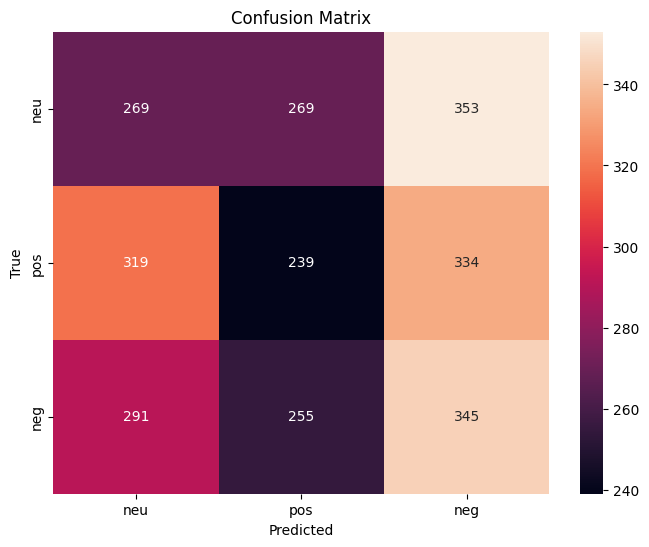

In [25]:
# Evaluate classification report
classification_report(y_test_original, predicted_labels)

# Plot confusion matrix using Seaborn
conf_matrix = confusion_matrix(y_test_original, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=['neu', 'pos', 'neg'], yticklabels=['neu', 'pos', 'neg'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Performance evaluation

<li> Check for the model predict wrong classes

In [56]:
incorrect_indices = np.where(predicted_labels != y_test_original)[0]

for index in incorrect_indices:
    print("Index:", index)
    print("Predicted Probabilities:", np.max(predictions[index], axis=0))
    print("Predicted Class:", predicted_labels[index])
    print("True Class:", y_test_original[index])
    print("Text:", test_df['texts'].iloc[index])
    print("\n")


เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย


Index: 1589
Predicted Probabilities: 0.63631904
Predicted Class: 2
True Class: 0
Text: ทีเอ็มเคท่ามะกาใข้ไหมคะ


Index: 1591
Predicted Probabilities: 0.96460927
Predicted Class: 0
True Class: 2
Text: พึ่งซื้อมาถ้าแล้วหน้าเทามากคะเสียดาย เปนที่เฉดผิวไม่ตรงรึป่าวคะ ต้องเป็นเบอร์อะไร ไม่เทา ปกติทาแต่รองพื้นแป้งเด็กหน้าไม่เทา พอมาเปลี่ยนดูเนียนคะแต่หน้าคล้ำไปเรย


Index: 1592
Predicted Probabilities: 0.68455344
Predicted Class: 2
True Class: 0
Text: ยังอยู่การเจ๋ง


Index: 1593
Predicted Probabilities: 0.5598226
Predicted Class: 2
True Class: 1
Text: เมื่อไหร่จะผอม


Index: 1595
Predicted Probabilities: 0.8037818
Predicted Class: 1
True Class: 0
Text: พรุ่งนี้ 5 ตุลาคม 2560 วันออกพรรษา ลานเบียร์ สิงห์ ลีโอ ช้าง บิ๊กซีดอนจั่น หยุดให้บริการ 1วันนะค่ะ


Index: 1597
Predicted Probabilities: 0.7015428
Predicted Class: 1
True Class: 2
Text: เมื่อ #ฝุ่นละออง ยังอยู่กับเราไม่ไปไหน ก็จะมาชี้เป้าหน้ากากกันฝุ่นให้เรื่อยๆ นะคะ เจอที่ beautrium

### Most wrongs predicted classes

  1. Class 1, which represents neutral sentiment, is the most misclassified.
     - This may be due to a higher representation of the neutral class in the dataset.
  2. The neutral class is particularly challenging to determine accurately.


In [60]:
from collections import Counter

misclassified_classes_counter = Counter(y_test_original[incorrect_indices])

# Find the most frequently misclassified class
most_wrong_class, misclassification_count = misclassified_classes_counter.most_common(1)[0]

for predicted_class, misclassification_count in misclassified_classes_counter.items():
    print(f"Predicted Class: {predicted_class}, Misclassification Count: {misclassification_count}")

Predicted Class: 1, Misclassification Count: 653
Predicted Class: 2, Misclassification Count: 546
Predicted Class: 0, Misclassification Count: 622


### Test model evaluation

In [26]:
input_text = "สวัสดีวันพฤหัส"

In [50]:
input_sequence = word_tokenize(input_text)

input_indices = [word_index[word] for word in input_sequence if word in word_index]

# Pad the sequence
padded_input = pad_sequences([input_indices], maxlen=max_length, padding='post')  # Assuming 'post' padding

# Make predictions
predicted_probabilities = model.predict(padded_input)

predicted_label = np.argmax(predicted_probabilities, axis=1)[0]

predicted_category = predicted_label

print("Input Text:", input_text)
print("Tokenized Input Sequence:", input_sequence)
print(f"Predicted Category, the ground truth label is {np.unique(train_df.category)}:", predicted_category) # class 2 is positve
print("Predicted Probabilities:", np.max(predicted_probabilities))

1/1 [==============================] - 0s 26ms/step
Input Text: สวัสดีวันพฤหัส
Tokenized Input Sequence: ['สวัสดี', 'วัน', 'พฤหัส']
Predicted Category, the ground truth label is ['neg' 'neu' 'pos']: 2
Predicted Probabilities: 0.72769374


### Conclusion

The model shows signs of overfitting due to data ambiguity. To address this, I've adjusted metrics and explored LSTM enhancements, including dropout, early stopping, and regularization. Future plans involve l
everaging pre-trained models when resources allow, along with a focus on feature engineering and data augmentation.